<a href="https://colab.research.google.com/github/chunbo777/dacon_prac/blob/main/corca_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 라이브러리 설치 및 import 

In [1]:
!pip install chart_studio

     |████████████████████████████████| 64 kB 1.8 MB/s 


In [3]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product, starmap
from keras import optimizers
from keras.utils.vis_utils import plot_model
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import chart_studio.plotly as py
# import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objects as go
%matplotlib inline
warnings.filterwarnings("ignore")
init_notebook_mode(connected = True)
import tensorflow
from numpy.random import seed
tensorflow.random.set_seed(1)
seed(1)

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Train, Test 데이터 불러오기 & EDA


In [82]:
train = pd.read_csv('/content/drive/MyDrive/corca/train.csv', parse_dates=['date'])
test = pd.read_csv('/content/drive/MyDrive/corca/test.csv', parse_dates=['date'])

In [83]:
print("----------------- train ------------------")
print(train.describe())
print("----------------- test ------------------")
print(test.describe())

----------------- train ------------------
               item          sales
count  730500.00000  730500.000000
mean       25.50000      50.610229
std        14.43088      27.830964
min         1.00000       0.000000
25%        13.00000      29.000000
50%        25.50000      45.000000
75%        38.00000      67.000000
max        50.00000     214.000000
----------------- test ------------------
                 id         item
count  45000.000000  45000.00000
mean   22499.500000     25.50000
std    12990.525394     14.43103
min        0.000000      1.00000
25%    11249.750000     13.00000
50%    22499.500000     25.50000
75%    33749.250000     38.00000
max    44999.000000     50.00000


In [84]:
print("----------------- train ------------------")
print(train.head())
print("----------------- test ------------------")
print(test.head())

----------------- train ------------------
        date store  item  sales
0 2013-01-01     A     1      8
1 2013-01-01     A     2     24
2 2013-01-01     A     3     21
3 2013-01-01     A     4     13
4 2013-01-01     A     5     29
----------------- test ------------------
   id       date store  item
0   0 2017-01-01     A     1
1   1 2017-01-01     A     2
2   2 2017-01-01     A     3
3   3 2017-01-01     A     4
4   4 2017-01-01     A     5


In [85]:

print("----------------- train info------------------")
print(train.info())
print("----------------- test info------------------")
print(test.info())

----------------- train info------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730500 entries, 0 to 730499
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    730500 non-null  datetime64[ns]
 1   store   730500 non-null  object        
 2   item    730500 non-null  int64         
 3   sales   730500 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 22.3+ MB
None
----------------- test info------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   id      45000 non-null  int64         
 1   date    45000 non-null  datetime64[ns]
 2   store   45000 non-null  object        
 3   item    45000 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 1.4+ MB
None


In [86]:
print("훈련데이터의 시작날과 마지막날- 시작날:",  train["date"].min().date() ,"마지막날:", train["date"].max().date())
print("검증데이터의 시작날과 마지막날- 시작날:",  test["date"].min().date() ,"마지막날:", test["date"].max().date())
print("필요관측일수:" , (test['date'].max().date() - train['date'].max().date()).days)

훈련데이터의 시작날과 마지막날- 시작날: 2013-01-01 마지막날: 2016-12-31
검증데이터의 시작날과 마지막날- 시작날: 2017-01-01 마지막날: 2017-03-31
필요관측일수: 90


데이터를 살펴보면 train data는 2013년부터 2016년말까지의 총 4년의 데이터이고,

test data는 2017년 3월 까지의 데이터로 3개월의 데이터이다. 

데이터의 피쳐의 측면에서 보면 train data는 sales를 포함하고, test data는 sales가 없다. 

태스크는 이 test data의 sales를 맞추는 일이다.


특이점은 test data에서는 id가 있지만 train data는 id가 없다는 점이다. 총 관측이 필요한 일수는 90일이다.

In [87]:
daily_sales = train.groupby('date', as_index = False)['sales'].sum() #일자별 매출
daily_sales_per_store = train.groupby(['store', 'date'], as_index = False)['sales'].sum() #매장별 일매출
daily_sales_per_items = train.groupby(['item', 'date'], as_index = False)['sales'].sum() #상품별 일매출

In [88]:
daily_sales_sc = go.Scatter(x = daily_sales['date'], y = daily_sales['sales'])

layout = go.Layout(title = '일일 매출량', 
                   xaxis=dict(title = '일자'), 
                   yaxis=dict(title = '매출'))

fig = go.Figure(data = [daily_sales_sc], 
                layout = layout)

fig.show(renderer = "colab")

store_daily_sales = []
for store in daily_sales_per_store['store'].unique():
    current_sales = daily_sales_per_store[(daily_sales_per_store['store'] == store)]
    store_daily_sales.append(go.Scatter(x = current_sales['date'], 
                                        y = current_sales['sales'], 
                                        name = ('%s 지점' % store)))

layout = go.Layout(title = '매장별 일매출', 
                   xaxis = dict(title = '일자'), 
                   yaxis = dict(title = '매출'))

fig = go.Figure(data=store_daily_sales, 
                layout=layout)

fig.show(renderer = "colab")

item_daily_sales = []
for item in daily_sales_per_items["item"].unique():
    current_sales_item = daily_sales_per_items[(daily_sales_per_items["item"] == item)]
    item_daily_sales.append(go.Scatter(x = current_sales_item["date"],
                                       y = current_sales_item["sales"],
                                       name = ("상품번호 %s" %item)))
layout = go.Layout(title = "상품별 일매출",
                   xaxis = dict(title = "일자"),
                   yaxis = dict(title = "매출")) 

fig = go.Figure(data=item_daily_sales, 
                layout=layout)

fig.show(renderer = "colab")   


In [89]:

for item in daily_sales_per_items["item"].unique():
    item_daily_sales = []
    current_sales_item = daily_sales_per_items[(daily_sales_per_items["item"] == item)]
    item_daily_sales.append(go.Scatter(x = current_sales_item["date"],
                                       y = current_sales_item["sales"],
                                       name = ("상품번호 %s" %item)))
    layout = go.Layout(title = "상품번호%s의 일매출" %item,
                    xaxis = dict(title = "일자"),
                    yaxis = dict(title = "매출")) 

    fig = go.Figure(data=item_daily_sales, 
                    layout=layout)

    fig.show(renderer = "colab")   

평균, 상품별, 매장별 일매출을 살펴보았다

전반적으로 계절적 추세를 보이며, 상품은 50가지로 너무 많아 각각의 추세를 살펴보아도 

계절추세에 어긋나는 유형의 그래프는 없었다.

또한 해가 갈수록 전반적으로 매출량이 올라가는 추세 또한 같았다.





# 데이터 전처리 및 정규화

데이터 전처리 및 정규화 과정은 다음과 같다.

1. 날짜별 (상점, 상품) 피벗테이블 만들기
2. Train data 와 Test data를 임시로 합치고, 원핫인코딩을 통해 각 날짜가 몇년도 몇월 무슨 요일인지 정보를 추가하기
3. 이전 날짜에 있는 데이터를 별도의 칼럼으로 이동 시키기  
4. Min-Max scaling
5. Train data와 test data 다시 나누기

In [90]:
# 전처리용 함수들
def storeitems():
    """
    총 row X column 만큼의 범위를 리턴해준다.
    """
    return product(range(1,51), range(1,11))

def making_pivot_map(df):
    """
    위 함수에서 처리된 범위에서 새로운 칼럼을 item과 store 별로 새로 만들고,
    해당 아이템과 매장의 매출을 값으로 지정한다.
     """
    pivotmap = pd.DataFrame(index = df.index.unique())
    for i, s in storeitems():
        pivotmap[f'(item, store) :({i}, {s})'] = df[(df['item'] == i) & (df['store'] == chr(s+64))]['sales'].values
    return pivotmap

def onehot_encoder(df, one_spot_indice, one_spot):
    """
    연도, 월, 요일의 원핫인코딩을 만든다
    """
    ret_df = pd.get_dummies(one_spot_indice, prefix =f"{one_spot}")
    ret_df.index = df.index
    return ret_df
def shift_series(series, days):
    """
    시리즈를 특정 시간만큼 이동시킨다.
    """
    return series.transform(lambda x : x.shift(days))

def storeitems_column_names():
    """
    아이템과 매장의 모든 조합을 튜플 리스트로 만든다.
    """
    return list(starmap(lambda i,s: f'(item, store) :({i}, {s})', storeitems()))


In [91]:
"""
datetimeIndex로 바꿔주는 과정.
각종 기능들(년도, 월, 요일)등을 사용하기 위해서 
데이터프레임 자체의 인덱스를 데이트타임 인덱스로 바꾼다.
"""

train['date'] = pd.to_datetime(train['date'])
df_train = train
df_train.index = pd.DatetimeIndex(df_train["date"])
df_train.drop("date", axis =1, inplace = True)

test['date'] = pd.to_datetime(test['date'])
df_test = test
df_test.index = pd.DatetimeIndex(df_test["date"])
df_test.drop("date", axis =1, inplace = True)

In [92]:
print("===================df train===================")
df_train.info()
print("===================df test===================")
df_test.info()

===================df train===================
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 730500 entries, 2013-01-01 to 2016-12-31
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   store   730500 non-null  object
 1   item    730500 non-null  int64 
 2   sales   730500 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 22.3+ MB
===================df test===================
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 45000 entries, 2017-01-01 to 2017-03-31
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      45000 non-null  int64 
 1   store   45000 non-null  object
 2   item    45000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.4+ MB


In [93]:
"""
train과 test를 모두 피벗테이블로 바꿔준다
"""

df_train = making_pivot_map(df_train)
#test의 sales는 0으로 채워놓는다.
df_test["sales"] = np.zeros(df_test.shape[0])
df_test = making_pivot_map(df_test)

원래 각 피쳐들로 들어 있었던 date, item, store를 정리하여 피벗테이블로 만든다. 모든 일자에 해당하는 (상품, 매장) 조합을 통해 모든 경우의 수를 고려할 수 있도록 한다. 편의상 A, B, C로 되어있던 매장 명을 숫자로 바꾸었다.

In [94]:
df_train.head()

(item, store) :(1, 1)  ...  (item, store) :(50, 10)
date                               ...                         
2013-01-01                      8  ...                       16
2013-01-02                      8  ...                       14
2013-01-03                      7  ...                       21
2013-01-04                      5  ...                       22
2013-01-05                      8  ...                       19

[5 rows x 500 columns]

In [95]:
df_test.head()

(item, store) :(1, 1)  ...  (item, store) :(50, 10)
date                               ...                         
2017-01-01                    0.0  ...                      0.0
2017-01-02                    0.0  ...                      0.0
2017-01-03                    0.0  ...                      0.0
2017-01-04                    0.0  ...                      0.0
2017-01-05                    0.0  ...                      0.0

[5 rows x 500 columns]

df_train과 df_test를 피벗테이블로 만들고 df_test의 경우 sales를 0으로 채워주었다.

# train data와 test데이터를 합치기


In [96]:
# 두 칼럼의 내용과 순서의 일치를 확인
for train_name, test_name in list(zip(df_train.columns, df_test.columns)):
    assert train_name == test_name

In [97]:
"""
추후에 트레인셋과 테스트셋을 다시 분리하기 위해서 별도의 칼럼 만들기
"""

df_test['is_test'] = np.repeat(True, df_test.shape[0])
df_train['is_test'] = np.repeat(False, df_train.shape[0])
df_total = pd.concat([df_train, df_test])

In [98]:
df_total.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1551 entries, 2013-01-01 to 2017-03-31
Columns: 501 entries, (item, store) :(1, 1) to is_test
dtypes: bool(1), float64(500)
memory usage: 5.9 MB


날짜지표를 원핫 인코딩으로 추가하기

In [99]:
weekday_onehot = onehot_encoder(df_total, df_total.index.weekday, "weekday")
month_onehot = onehot_encoder(df_total, df_total.index.month, "month")
year_onehot = onehot_encoder(df_total, df_total.index.year, "year")

In [100]:
"""
50(아이템)* 10(상점) + 24(날짜 정보 원핫인코딩) + 1(트레인/테스트 데이터 구별용 임시 칼럼)
"""
df_total = pd.concat([year_onehot, weekday_onehot, month_onehot, df_total], axis = 1)
df_total.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1551 entries, 2013-01-01 to 2017-03-31
Columns: 525 entries, year_2013 to is_test
dtypes: bool(1), float64(500), uint8(24)
memory usage: 6.0 MB


In [101]:
df_total.head()

year_2013  year_2014  ...  (item, store) :(50, 10)  is_test
date                              ...                                  
2013-01-01          1          0  ...                     16.0    False
2013-01-02          1          0  ...                     14.0    False
2013-01-03          1          0  ...                     21.0    False
2013-01-04          1          0  ...                     22.0    False
2013-01-05          1          0  ...                     19.0    False

[5 rows x 525 columns]

In [102]:
def shift_series_in_df(df, series_names = [], days_delta = 90):
    """
    시간이동에 따라 이름 재설정된 데이터프레임 제공
    """
    ret = pd.DataFrame(index = df.index.copy())
    str_sgn = "future" if np.sign(days_delta) < 0 else "past"
    for sn in series_names:
        ret[f"{sn}_{str_sgn}_{np.abs(days_delta)}"] = shift_series(df[sn], days_delta)
    return ret



def stack_shifted_sales(df, days_delta = 90):
    """
    타임 lag에 따른 데이터 만들기
    """
    names =  storeitems_column_names()
    dfs = [df.copy()]
    abs_range =  range(1, days_delta + 1) if days_delta > 0 else range(days_delta, 0) 
    # days_delta가 0보다 클 경우 1부터 days_delta까지, 0보다 작으면 days_delta부터 1까지 역순
    for day_offset in abs_range:
        delta = -day_offset
        shifted = shift_series_in_df(df, series_names = names, days_delta = delta)
        dfs.append(shifted)
    return pd.concat(dfs, axis = 1, copy = False)

In [103]:
df_total =  stack_shifted_sales(df_total, days_delta=-3)

In [104]:
df_total = df_total.dropna()

In [105]:
df_total.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1548 entries, 2013-01-04 to 2017-03-31
Columns: 2025 entries, year_2013 to (item, store) :(50, 10)_past_1
dtypes: bool(1), float64(2000), uint8(24)
memory usage: 23.7 MB


In [106]:
df_total.head()

year_2013  ...  (item, store) :(50, 10)_past_1
date                   ...                                
2013-01-04          1  ...                            21.0
2013-01-05          1  ...                            22.0
2013-01-06          1  ...                            19.0
2013-01-07          1  ...                            17.0
2013-01-08          1  ...                            20.0

[5 rows x 2025 columns]

In [107]:
""""특성에 따라 칼럼들을 구분"""

sales_cols = [col for col in df_total.columns if "store" in col and "_past_" not in col]
stacked_sales_cols = [col for col in df_total.columns if "_past_" in col]
other_cols = [col for col in df_total.columns if col not in set(sales_cols) and col not in set(stacked_sales_cols)]

In [108]:
sales_cols = sorted(sales_cols)
stacked_sales_cols = sorted(stacked_sales_cols)
new_cols = other_cols + stacked_sales_cols + sales_cols

In [109]:
df_total = df_total.reindex(columns = new_cols)

In [110]:
df_total.head()

year_2013  year_2014  ...  (item, store) :(9, 8)  (item, store) :(9, 9)
date                              ...                                              
2013-01-04          1          0  ...                   64.0                   45.0
2013-01-05          1          0  ...                   56.0                   55.0
2013-01-06          1          0  ...                   54.0                   53.0
2013-01-07          1          0  ...                   41.0                   29.0
2013-01-08          1          0  ...                   51.0                   37.0

[5 rows x 2025 columns]

In [111]:
assert df_total.isna().any().any() == False

# 정규화

In [112]:
#min-max scaling

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

cols_to_scale = [col for col in df_total.columns if "weekday" not in col and "month" not in col and "year" not in col]

In [113]:
scaler = MinMaxScaler()
scaled_cols = scaler.fit_transform(df_total[cols_to_scale])
df_total[cols_to_scale] = scaled_cols
df_total.head()

year_2013  year_2014  ...  (item, store) :(9, 8)  (item, store) :(9, 9)
date                              ...                                              
2013-01-04          1          0  ...               0.387879               0.346154
2013-01-05          1          0  ...               0.339394               0.423077
2013-01-06          1          0  ...               0.327273               0.407692
2013-01-07          1          0  ...               0.248485               0.223077
2013-01-08          1          0  ...               0.309091               0.284615

[5 rows x 2025 columns]

# train, test data 다시 나누기


In [114]:
"""임시 지표를 기준으로 다시 나누기"""

df_train = df_total[df_total["is_test"] == False].drop("is_test", axis = 1)
df_test = df_total[df_total["is_test"] == True].drop("is_test", axis = 1)

In [115]:
""" 과거 지표 , 시간 지표 따로 나누기 """

X_cols_stacked = [col for col in df_train.columns if "_past_" in col]
X_cols_caldata = [col for col in df_train.columns if "weekday_" in col or "month_" in col or "year_" in col]
X_cols = X_cols_stacked + X_cols_caldata #lag데이터와 시간 데이터만 남김
X = df_train[X_cols]

In [116]:
X_colset= set(X_cols) #lag, 시간 데이터
y_cols = [col for col in df_train.columns if col not in X_colset] #x_colset 이외의 칼럼들 = 일반데이터
y = df_train[y_cols]


In [117]:
X.info()
y.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1458 entries, 2013-01-04 to 2016-12-31
Columns: 1524 entries, (item, store) :(1, 1)_past_1 to month_12
dtypes: float64(1500), uint8(24)
memory usage: 16.7 MB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1458 entries, 2013-01-04 to 2016-12-31
Columns: 500 entries, (item, store) :(1, 1) to (item, store) :(9, 9)
dtypes: float64(500)
memory usage: 5.6 MB


In [118]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, shuffle = False)
X_train_vals = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_valid_vals = X_valid.values.reshape((X_valid.shape[0], 1, X_valid.shape[1]))


#LSTM Training

convolutional neural network와 lstm으로 구성된 모델을 통해 학습시켜줍니다.

In [119]:
from keras.models import Sequential, Model
from keras.layers import *

def build_model():
    inputs = Input(shape = (X_train_vals.shape[1], X_train_vals.shape[2]))
    top_lstm = LSTM(500, return_sequences=True)(inputs)
    top_dense = Dense(500, activation="relu")(top_lstm)

    bottom_dense = Dense(500)(inputs)
    bottom_conv1 = Conv1D(
        500,
        kernel_size = 1,
        input_shape = (X_train_vals.shape[1], X_train_vals.shape[2])
    )(bottom_dense)
    bottom_conv2 = Conv1D(
        1000,
        kernel_size = 50,
        padding ="same",
        activation = "relu"
    )(bottom_conv1)
    bottom_conv3 = Conv1D(
        500,
        kernel_size =10,
        padding = "same",
        activation = "relu"
    )(bottom_conv2)
    bottom_pooling = AvgPool1D(
        pool_size =10,
        padding = "same"
    )(bottom_conv3)

    final_concat = Concatenate()([top_dense, bottom_pooling])
    final_lstm = LSTM(1000, dropout = 0.2)(final_concat)
    final_dense = Dense(500)(final_lstm)

    model = Model(inputs = inputs, outputs = final_dense)
    model.compile(loss = "mean_absolute_error", optimizer ="adam", metrics =["mape"])
    return model

model = build_model()

In [120]:
history = model.fit(
    X_train_vals,
    y_train.values,
    epochs =130,
    batch_size =70,
    validation_data = (X_valid_vals, y_valid.values),
    verbose =2,
    shuffle = False
)

Epoch 1/130
17/17 - 14s - loss: 0.2012 - mape: 501.9785 - val_loss: 0.1522 - val_mape: 24.5632 - 14s/epoch - 851ms/step
Epoch 2/130
17/17 - 1s - loss: 0.1189 - mape: 574.5175 - val_loss: 0.1591 - val_mape: 25.1354 - 717ms/epoch - 42ms/step
Epoch 3/130
17/17 - 1s - loss: 0.1133 - mape: 627.2391 - val_loss: 0.1412 - val_mape: 22.4449 - 717ms/epoch - 42ms/step
Epoch 4/130
17/17 - 1s - loss: 0.1114 - mape: 626.6341 - val_loss: 0.1226 - val_mape: 20.0984 - 713ms/epoch - 42ms/step
Epoch 5/130
17/17 - 1s - loss: 0.1066 - mape: 582.1459 - val_loss: 0.1264 - val_mape: 20.3776 - 715ms/epoch - 42ms/step
Epoch 6/130
17/17 - 1s - loss: 0.1058 - mape: 658.9945 - val_loss: 0.1159 - val_mape: 19.0805 - 712ms/epoch - 42ms/step
Epoch 7/130
17/17 - 1s - loss: 0.1038 - mape: 601.8934 - val_loss: 0.1170 - val_mape: 19.0969 - 715ms/epoch - 42ms/step
Epoch 8/130
17/17 - 1s - loss: 0.1003 - mape: 624.8469 - val_loss: 0.1139 - val_mape: 18.6494 - 716ms/epoch - 42ms/step
Epoch 9/130
17/17 - 1s - loss: 0.0954 - 

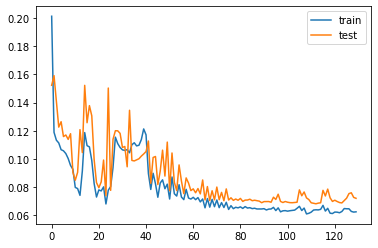

In [121]:
plt.plot(history.history["loss"], label = "train")
plt.plot(history.history["val_loss"], label = "test")
plt.legend()
plt.show()

In [122]:
X_valid.shape

(292, 1524)

In [123]:
y_valid.shape

(292, 500)

손실함수는 symmetric mean absolute percentage error를 사용하였다.
이하 smape.
https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error

In [141]:

def model_eval(model, X_test, y_test, log_all = False):
    sales_x_cols = [col for col in X_test.columns if "store" in col]
    sales_x_idxs = [X_test.columns.get_loc(col) for col in sales_x_cols]
    sales_y_cols = [col for col in y_test.columns if "store" in col]
    sales_y_idxs = [y_test.columns.get_loc(col) for col in sales_y_cols]
    n_samples = y_test.shape[0]
    print(X_test.shape, y_test.shape)
    y_pred = np.zeros(y_test.shape)
    x_next = X_test.iloc[0].values
    for i in range(0, n_samples):
        if log_all :
            print("[x]", x_next)
        x_arr = np.array([x_next])
        x_arr = x_arr.reshape(x_arr.shape[0], 1, x_arr.shape[1])
        y_pred[i] = model.predict(x_arr)[0]
        try :
            x_next = X_test.iloc[i+1].values
            x_next[sales_x_idxs] = y_pred[i][sales_y_idxs]
        except :
            pass
    return y_pred, y_test.values

def vector_smape(y_pred, y_real):
    nom = np.abs(y_pred - y_real)
    denom = (np.abs(y_pred) +  np.abs(y_real)) / 2
    results = nom/denom
    return 100*np.mean(results) 


In [142]:
X_valid, y_valid = X_valid.head(90), y_valid.head(90)

In [130]:
def unscale(y_arr, scaler, template_df, toint=False):
    """정규화된 것을 다시 원래 형태로 변환"""
    tmp = template_df.copy()
    tmp[y_cols] = pd.DataFrame(y_arr, index = tmp.index)
    tmp[cols_to_scale] = scaler.inverse_transform(tmp[cols_to_scale])
    if toint:
        return tmp[y_cols].astype(int)
    return tmp[y_cols]



In [131]:
template_df = pd.concat([X_valid, y_valid], axis=1)
template_df['is_test'] = np.repeat(True, template_df.shape[0])


In [136]:
pred = unscale(y_pred, scaler, template_df, toint=True)
real = unscale(y_real, scaler, template_df, toint=True)

In [144]:
smapes = [vector_smape(pred[col], real[col]) for col in pred.columns]

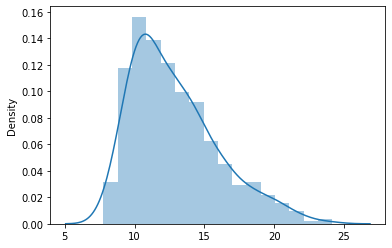

In [147]:
sns.distplot(smapes)

In [151]:
store, item = np.random.randint(1,11), np.random.randint(1,51)
random_storeitem_col = f'(item, store) :({item}, {store})'

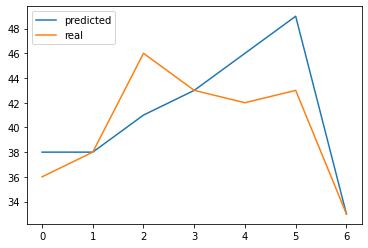

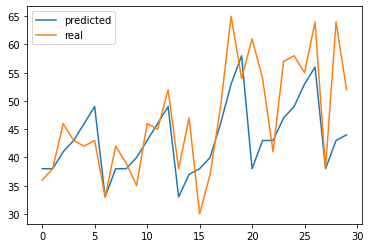

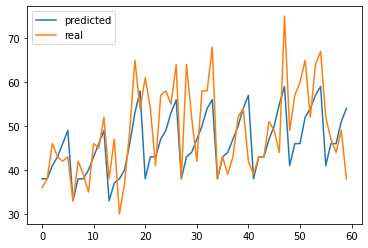

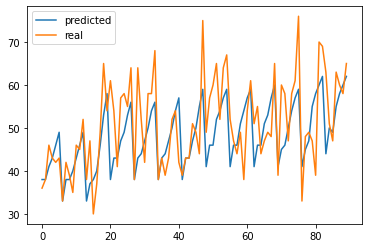

In [152]:
plot_lengths = [7, 30, 60, 365]

for pl in plot_lengths:
    plt.plot(pred[random_storeitem_col].values[:pl], label='predicted')
    plt.plot(real[random_storeitem_col].values[:pl], label='real')
    plt.legend()
    plt.show()

In [153]:
df_test[stacked_sales_cols].head(2)

(item, store) :(1, 1)_past_1  ...  (item, store) :(9, 9)_past_3
date                                      ...                              
2017-01-01                      0.243902  ...                      0.407692
2017-01-02                      0.000000  ...                      0.369231

[2 rows x 1500 columns]

In [154]:
X_test, y_test = df_test[X_cols], df_test[y_cols]

In [155]:
y_test_pred, _ = model_eval(model, X_test, y_test)

(90, 1524) (90, 500)


In [156]:
test_template_df = pd.concat([X_test, y_test], axis=1)
test_template_df['is_test'] = np.repeat(True, test_template_df.shape[0])

test_pred = unscale(y_test_pred, scaler, test_template_df, toint=True)

In [157]:
test_pred.head()

(item, store) :(1, 1)  ...  (item, store) :(9, 9)
date                               ...                       
2017-01-01                     14  ...                     69
2017-01-02                      5  ...                     30
2017-01-03                      4  ...                     28
2017-01-04                      5  ...                     24
2017-01-05                      5  ...                     24

[5 rows x 500 columns]